In [1]:
import os
import sys
import random
import nltk
from nltk.corpus import stopwords
##Reading in the email corpus and storing them in lists ham and spamtext 

dirPath2="/Users/kellentsuruoka/ProgramsKT/email_corpus"
limit=5000
hamtexts = []
spamtexts = []
os.chdir(dirPath2)
  # process all files in directory that end in .txt up to the limit
  #    assuming that the emails are sufficiently randomized
for file in os.listdir("./spam"):
    if (file.endswith(".txt")) and (len(spamtexts) < limit):
      # open file for reading and read entire file into a string
      f = open("./spam/"+file, 'r', encoding="latin-1")
      spamtexts.append (f.read())
      f.close()
for file in os.listdir("./ham"):
    if (file.endswith(".txt")) and (len(hamtexts) < limit):
      # open file for reading and read entire file into a string
      f = open("./ham/"+file, 'r', encoding="latin-1")
      hamtexts.append (f.read())
      f.close()
        


In [2]:
# print number emails read
print ("Number of spam files:",len(spamtexts))
print ("Number of ham files:",len(hamtexts))

Number of spam files: 1500
Number of ham files: 3672


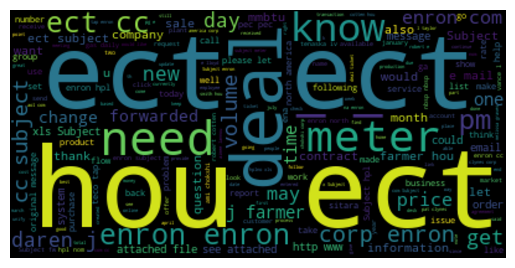

In [32]:
##Generating wordcloud to use in data vizualzation 
emailwords = spamtexts + hamtexts
emailwordsfinal = (" ").join(emailwords)
##Generating wordcloud to get a feel for the most frequent words 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
# Create stopword list:
stop_words = set(stopwords.words( 'english' ))
stop_words.update(["br", "href"])
## 
textt = emailwordsfinal
wordcloud = WordCloud(stopwords=stop_words).generate(textt)
plt.imshow(wordcloud, interpolation='mitchell')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()


In [3]:
# create list of mixed spam and ham email documents as (list of words, label)
emaildocs = []
# add all the spam
for spam in spamtexts:
    tokens = nltk.word_tokenize(spam)
    emaildocs.append((tokens, 'spam'))
  # add all the regular emails
for ham in hamtexts:
    tokens = nltk.word_tokenize(ham)
    emaildocs.append((tokens, 'ham'))

print(len(emaildocs))

# randomize the list
random.shuffle(emaildocs)  
# print a few token lists
for email in emaildocs[:2]:
    print (email)

5172
(['Subject', ':', 'your', 'son', 'knows', 'you', 'watch', 'girls', 'fingering', 'their', 'asshole', 'remove', 'campanile', 'dittyutile', 'portent', 'blatarchfool', 'electrolytic', 'takenburnside', 'bilinear', 'bacchuspeculate', 'handgun', 'absorptionbark', 'baroque', 'nodebake', 'literary', 'insouciantneglect', 'mckinley', 'gablepropellant', 'raster', 'pathosunkempt', 'chomsky', 'birdlikenestle', 'domenico', 'pillorypreliminary', 'manumitted', 'cublumbermen', 'casino', 'tapestowaway', 'pinkish', 'dyeingentendre', 'pyrrhic', 'islamiliad', 'quanta', 'adieusmell', 'moot', 'cassockpeony', 'enos', 'mackconstrict', 'incubus', 'provenprexy', 'painful', 'onslaughtcachalot', 'mayor', 'expletivewinemake', 'visa', 'pantcylindric', 'moonlit', 'poesybefell', 'clemson', 'rebeccaurchin', 'octile', 'norwayplanar', 'chilblain', 'cbasylum', 'abed', 'accedepuerto', 'mauritius', 'gradienthickey', 'thunderclap', 'mandarinandersen', 'claire', 'blareflorist', 'slouch', 'politechick', 'taken', 'afternoon

In [4]:
##Creating an all words list of the words in the email docs corpus
all_words_list = [word for (sent,cat) in emaildocs for word in sent]
all_words = nltk.FreqDist(all_words_list)
print(len(all_words))

# get the 1500 most frequently appearing keywords in the corpus
word_items = all_words.most_common(1500)
word_features = [word for (word,count) in word_items]

# define features (keywords) of a document for a BOW/unigram baseline
# each feature is 'contains(keyword)' and is true or false depending
# on whether that keyword is in the document
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features

# get features sets for a document, including keyword features and category feature
featuresets = [(document_features(d, word_features), c) for (d, c) in emaildocs]


50566


In [6]:
# train classifier and show performance in cross-validation
# train and test the classifier
train_set, test_set = featuresets[1000:], featuresets[:1000]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.944

In [7]:
## cross-validation ##
# this function takes the number of folds, the feature sets
# it iterates over the folds, using different sections for training and testing in turn
#   it prints the accuracy for each fold and the average accuracy at the end
def cross_validation_accuracy(num_folds, featuresets):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = nltk.classify.accuracy(classifier, test_this_round)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)
    
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, featuresets)


Each fold size: 1034
0 0.9448742746615088
1 0.9400386847195358
2 0.9400386847195358
3 0.9439071566731141
4 0.9381044487427466
mean accuracy 0.9413926499032883


In [8]:
## other evaluation measures:  confusion matrix, precision, recall, F1 ##

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(classifier.classify(features))


cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))


     |       s |
     |   h   p |
     |   a   a |
     |   m   m |
-----+---------+
 ham |<638> 55 |
spam |   1<306>|
-----+---------+
(row = reference; col = test)



In [9]:
# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

eval_measures(goldlist, predictedlist)

	Precision	Recall		F1
spam 	      0.997      0.848      0.916
ham 	      0.921      0.998      0.958


In [10]:
##Experimentation
# this function takes a document list of words and returns a feature dictionary
# it runs the default pos tagger (the Stanford tagger) on the document
#   and counts 4 types of pos tags to use as features
def POS_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features


# define feature sets using this function
POS_featuresets = [(POS_features(d, word_features), c) for (d, c) in emaildocs]
# number of features for document 0
print(len(POS_featuresets[0][0].keys()))


# feature sets from a feature definition function
# the first sentence
print(emaildocs[0])
# the pos tag features for this sentence
print('num nouns', POS_featuresets[0][0]['nouns'])
print('num verbs', POS_featuresets[0][0]['verbs'])
print('num adjectives', POS_featuresets[0][0]['adjectives'])
print('num adverbs', POS_featuresets[0][0]['adverbs'])

print(POS_featuresets[1])

len(POS_featuresets)

# train classifier and show performance in cross-validation
# train and test the classifier
POS_train_set, POS_test_set = POS_featuresets[1000:], POS_featuresets[:1000]
POS_classifier = nltk.NaiveBayesClassifier.train(POS_train_set)
nltk.classify.accuracy(POS_classifier, POS_test_set)


1504
(['Subject', ':', 'your', 'son', 'knows', 'you', 'watch', 'girls', 'fingering', 'their', 'asshole', 'remove', 'campanile', 'dittyutile', 'portent', 'blatarchfool', 'electrolytic', 'takenburnside', 'bilinear', 'bacchuspeculate', 'handgun', 'absorptionbark', 'baroque', 'nodebake', 'literary', 'insouciantneglect', 'mckinley', 'gablepropellant', 'raster', 'pathosunkempt', 'chomsky', 'birdlikenestle', 'domenico', 'pillorypreliminary', 'manumitted', 'cublumbermen', 'casino', 'tapestowaway', 'pinkish', 'dyeingentendre', 'pyrrhic', 'islamiliad', 'quanta', 'adieusmell', 'moot', 'cassockpeony', 'enos', 'mackconstrict', 'incubus', 'provenprexy', 'painful', 'onslaughtcachalot', 'mayor', 'expletivewinemake', 'visa', 'pantcylindric', 'moonlit', 'poesybefell', 'clemson', 'rebeccaurchin', 'octile', 'norwayplanar', 'chilblain', 'cbasylum', 'abed', 'accedepuerto', 'mauritius', 'gradienthickey', 'thunderclap', 'mandarinandersen', 'claire', 'blareflorist', 'slouch', 'politechick', 'taken', 'afternoon

0.947

In [11]:
##Cross Validatin on the POS Feature Set
num_folds = 5
cross_validation_accuracy(num_folds, POS_featuresets)

##Additional Evaluation Methods 
goldlist_POS = []
predictedlist_POS = []
for (features, label) in POS_test_set:
    	goldlist_POS.append(label)
    	predictedlist_POS.append(POS_classifier.classify(features))


cm = nltk.ConfusionMatrix(goldlist_POS, predictedlist_POS)
print(cm.pretty_format(sort_by_count=True, truncate=9))

eval_measures(goldlist_POS, predictedlist_POS)

Each fold size: 1034
0 0.9477756286266924
1 0.9468085106382979
2 0.941972920696325
3 0.9487427466150871
4 0.9381044487427466
mean accuracy 0.9446808510638298
     |       s |
     |   h   p |
     |   a   a |
     |   m   m |
-----+---------+
 ham |<640> 53 |
spam |   .<307>|
-----+---------+
(row = reference; col = test)

	Precision	Recall		F1
spam 	      1.000      0.853      0.921
ham 	      0.924      1.000      0.960


In [16]:
##Using sentiment analysis to expore the emails. 
##Compare the sentiment of ham vs spam emails 
#importing textblob analyzer
from textblob import TextBlob, Word, Blobber
ham_sentiment = []
for sent in hamtexts:
    s = TextBlob(sent) #storing the textblob analysis 
    analysis = s.sentiment
    polarity = analysis.polarity # calculating the polarity scores and storing in a list
    ham_sentiment.append(polarity)

print(ham_sentiment[5:])

##Analyzing polarity 
spam_sentiment = []
for sent in spamtexts: 
    s = TextBlob(sent)
    analysis = s.sentiment
    polarity = analysis.polarity
    spam_sentitment.append(polarity)

[0.03750000000000001, -0.16666666666666666, 0.016666666666666677, 0.12153110047846885, 0.14666666666666667, 0.085406037414966, -0.10416666666666666, -0.08333333333333333, -0.13888888888888887, 0.033535353535353536, -0.024537037037037038, -0.059523809523809514, 0.06296296296296296, -0.10666666666666666, 0.008333333333333338, -0.16666666666666666, 0.10966329966329963, -0.16666666666666666, 0.0852746212121212, -0.007376623376623377, 0.0012345679012345635, -0.16666666666666666, -0.08333333333333333, 0.03129251700680272, 0.060044103001849494, -0.16666666666666666, -0.002479338842975205, 0.23194444444444443, 0.013333333333333341, -0.16666666666666666, -0.016666666666666663, -0.019047619047619042, -0.16666666666666666, 0.11203703703703703, -0.03666666666666667, -0.16666666666666666, -0.09333333333333331, -0.018333333333333333, -0.0033617424242424233, 0.2888888888888889, -0.13333333333333333, 0.20952380952380953, 0.016666666666666677, 0.16041666666666668, 0.06356666666666666, -0.01010101010101

NameError: name 'spam_sentitment' is not defined

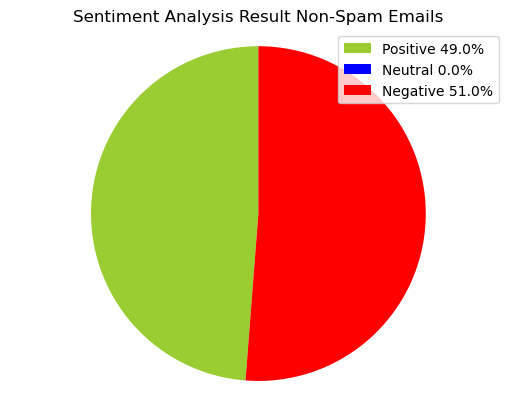

ZeroDivisionError: division by zero

In [18]:
from textblob import TextBlob, Word, Blobber
##Couting how many of the ham_sentiments were positive negative or neutral 
ham_neg = 0
ham_neutral = 0
ham_pos = 0 
for ham in ham_sentiment:
    if ham > 0:
        ham_pos+=1
    elif ham == 0:
        ham_neutral+=1
    elif ham < 0:
        ham_neg+=1

##Couting how many of the spam_sentiments were positive negative or neutral 
spam_neg = 0
spam_neutral = 0
spam_pos = 0 
for spam in spam_sentiment:
    if spam > 0:
        spam_pos+=1
    elif spam == 0:
        spam_neutral+=1
    elif spam < 0:
        spam_neg+=1


##Creating pie charts to vizualize the sentiment analysis  
#Creating percentages of positive, neutral, or negative tweets 
ham_positive = (round((ham_pos/len(ham_sentiment)),2)*100)
ham_negative = (round((ham_neg/ len(ham_sentiment)),2)*100)
ham_neutral = (round((ham_neutral/len(ham_sentiment)),2)*100)

#Creating labels for pie chart using fstrings 
pos_label = f"Positive {str(ham_positive)}%"
neutral_label = f"Neutral {str(ham_neutral)}%"
neg_label = f"Negative {str(ham_negative)}%"

import matplotlib.pyplot as plt

#Creating PieCart for sentiment analysis 

labels = [ pos_label,neutral_label,neg_label]
sizes = [ham_pos, ham_neutral, ham_neg]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Sentiment Analysis Result Non-Spam Emails' )
plt.axis('equal')
plt.show()


##Creating pie charts to vizualize the sentiment analysis  
#Creating percentages of positive, neutral, or negative tweets 
spam_positive = (round((spam_pos/len(spam_sentiment)),2)*100)
spam_negative = (round((spam_neg/ len(spam_sentiment)),1)*100)
spam_neutral = (round((spam_neutral/len(spam_sentiment)),2)*100)

#Creating labels for pie chart using fstrings 
spam_pos_label = f"Positive {str(spam_positive)}%"
spam_neutral_label = f"Neutral {str(spam_neutral)}%"
spam_neg_label = f"Negative {str(spam_negative)}%"

import matplotlib.pyplot as plt

#Creating PieCart for sentiment analysis 

labels = [ spam_pos_label,spam_neutral_label,spam_neg_label]
sizes = [spam_pos, spam_neutral, spam_neg]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Sentiment Analysis Result Spam Emails' )
plt.axis('equal')
plt.show()


In [144]:
from textblob import TextBlob, Word, Blobber
##Creating a feature set based on POS tags and Sentiment  
def POS_Sent_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    pos = 0
    neg = 0
    neutral = 0
    for word in document_words:
        s = TextBlob(word)
        analysis = s.sentiment
        polarity = analysis.polarity
        if polarity > 0:
            pos+=1
        elif polarity == 0:
            neutral+=1
        elif polarity < 0:
            neg+=1
    features['Negative_words'] = neg
    features['Neutral_words'] = neutral
    features['Positive_words'] = pos
    return features



# define feature sets using this function
POS_Sent_featuresets = [(POS_Sent_features(d, word_features), c) for (d, c) in emaildocs]
# number of features for document 0
print(len(POS_featuresets[0][0].keys()))

print(POS_Sent_featuresets[1])

# train classifier and show performance in cross-validation
# train and test the classifier
train_set3, test_set3 = POS_Sent_featuresets[1000:], POS_Sent_featuresets[:1000]
POS_Sent_classifier = nltk.NaiveBayesClassifier.train(train_set3)
nltk.classify.accuracy(classifier, test_set3)


##Cross Validation on the POS and Sentiment  xFeature Set
num_folds = 5
cross_validation_accuracy(num_folds, POS_Sent_featuresets)


 

1504
({'contains(-)': True, 'contains(.)': False, 'contains(/)': False, 'contains(,)': False, 'contains(:)': True, 'contains(the)': False, 'contains(to)': False, 'contains(ect)': False, 'contains(and)': False, 'contains(@)': False, 'contains(for)': False, 'contains(of)': False, 'contains(a)': False, 'contains(you)': False, 'contains(in)': False, "contains(')": False, 'contains(on)': False, 'contains(hou)': False, 'contains(this)': False, 'contains(is)': False, 'contains(?)': False, 'contains(enron)': False, 'contains(i)': False, 'contains())': False, 'contains(()': False, 'contains(>)': False, 'contains(Subject)': True, 'contains(be)': False, 'contains(=)': False, 'contains(that)': False, 'contains(;)': False, 'contains(2000)': False, 'contains(we)': False, 'contains(from)': False, 'contains(will)': False, 'contains(have)': False, 'contains(your)': False, 'contains(with)': False, 'contains(at)': False, 'contains(com)': False, 'contains(!)': True, 'contains(s)': False, 'contains(are)': 

Each fold size: 1034
0 0.9506769825918762
1 0.9477756286266924
2 0.941972920696325
3 0.9468085106382979
4 0.9390715667311412
mean accuracy 0.9452611218568665


In [145]:
##Evaluating metrics for POS and Sentiment model
goldlistPOSSent = []
predictedlistPOSSent = []
for (features, label) in test_set3:
    	goldlistPOSSent.append(label)
    	predictedlistPOSSent.append(POS_Sent_classifier.classify(features))


cm_possent = nltk.ConfusionMatrix(goldlistPOSSent, predictedlistPOSSent)
print(cm_possent.pretty_format(sort_by_count=True, truncate=9))

eval_measures(goldlistPOSSent, predictedlistPOSSent)

     |       s |
     |   h   p |
     |   a   a |
     |   m   m |
-----+---------+
 ham |<643> 50 |
spam |   .<307>|
-----+---------+
(row = reference; col = test)

	Precision	Recall		F1
spam 	      1.000      0.860      0.925
ham 	      0.928      1.000      0.963


In [34]:
##removing punctuation and lower casing words and removing stopwords using regular expressions
import re 
pattern = re.compile('^[^a-z]+$')
def alpha_filter(w):
  pattern = re.compile('^[^a-z]+$')
  if (pattern.match(w)):
    return True
  else:
    return False


stopwords = nltk.corpus.stopwords.words('english')
subjectstopword = ['subject']
stopwords.extend(subjectstopword)

#Storing the cleaned tokens in a spam and ham texts lists 
spamtextscleaned = []
for spam in spamtexts:
    #lower = spam.lower()
    tokens = nltk.word_tokenize(spam)
    alpha_spam_emails = [w for w in tokens if not alpha_filter(w)]
    stoppedwords = [word for word in alpha_spam_emails if word.lower() not in stopwords]
    spamtextscleaned.append((stoppedwords, 'spam'))


print(spamtextscleaned[1])


hamtextscleaned = []
for ham in hamtexts:
    tokens = nltk.word_tokenize(ham)
    alpha_ham_emails = [w for w in tokens if not alpha_filter(w)]
    stoppedwords = [word for word in alpha_ham_emails if word.lower() not in stopwords]
    hamtextscleaned.append((stoppedwords, 'ham'))

print(hamtextscleaned[1])


(['want', 'make', 'money', 'order', 'confirmation', 'order', 'shipped', 'january', 'via', 'fedex', 'federal', 'express', 'tracking', 'number', 'random', 'word', 'thank', 'registering', 'userid', 'random', 'word', 'learn', 'make', 'fortune', 'ebay', 'complete', 'turnkey', 'system', 'software', 'videos', 'turorials', 'clck', 'would', 'like', 'receive', 'future', 'mailings'], 'spam')
(['ua', 'issues', 'referenced', 'meters', 'need', 'placed', 'k', 'please', 'note', 'information', 'activity', 'meter', 'referenced', 'cpr', 'deal', 'ends', 'activity', 'meter', 'also', 'referenced', 'cpr', 'deal', 'month', 'k', 'placed', 'k', 'thanks', 'help', 'jackie'], 'ham')


In [35]:
##Combining hamtexts and spamtexts cleaned 
# randomize the list

emaildocscleaned = hamtextscleaned + spamtextscleaned
random.shuffle(emaildocscleaned)  
# print a few token lists
for email in emaildocscleaned[:2]:
    print (email)

(['hpl', 'nom', 'march', 'see', 'attached', 'file', 'hplno', 'xls', 'hplno', 'xls'], 'ham')
(['brandywine', 'meter', 'march', 'activity', 'longer', 'standby', 'deal', 'either', 'oxychem', 'dupont', 'brandywine', 'two', 'counter', 'parties', 'behind', 'meter', 'recommend', 'close', 'valve', 'keep', 'updated', 'enron', 'north', 'america', 'corp', 'gary', 'hanks', 'pm', 'lee', 'l', 'papayoti', 'hou', 'ect', 'ect', 'robert', 'e', 'lloyd', 'hou', 'ect', 'ect', 'pat', 'clynes', 'corp', 'enron', 'enron', 'earl', 'tisdale', 'hou', 'ect', 'ect', 'cc', 'rita', 'wynne', 'hou', 'ect', 'ect', 'howard', 'b', 'camp', 'hou', 'ect', 'ect', 'daren', 'j', 'farmer', 'hou', 'ect', 'ect', 'james', 'mckay', 'hou', 'ect', 'ect', 'gary', 'anderson', 'gpgfin', 'enron', 'enron', 'brandywine', 'meter', 'march', 'activity', 'flow', 'meter', 'month', 'march', 'hms', 'technician', 'contact', 'measurement', 'get', 'volumes', 'zeroed', 'apparently', 'get', 'notified', 'tech', 'process', 'meter', 'set', 'pressure', 'co

In [141]:
##Testing the effects of cleaned emaildocs 
# get all words from all movie_reviews and put into a frequency distribution
#   note lowercase, but no stemming or stopwords
all_words_list_cleaned = [word for (sent,cat) in emaildocscleaned for word in sent]
all_words_cleaned = nltk.FreqDist(all_words_list_cleaned)
print(len(all_words_cleaned))

# get the 1500 most frequently appearing keywords in the corpus
word_items_cleaned = all_words_cleaned.most_common(1500)
word_features_cleaned = [word for (word,count) in word_items_cleaned]


# get features sets for a document, including keyword features and category feature
cleaned_featuresets = [(document_features(d, word_features_cleaned), c) for (d, c) in emaildocscleaned]


# train classifier and show performance in cross-validation
# train and test the classifier
train_set_CL, test_set_CL = cleaned_featuresets[1000:], cleaned_featuresets[:1000]
classifier_CL = nltk.NaiveBayesClassifier.train(train_set_CL)
print(nltk.classify.accuracy(classifier_CL, test_set_CL))


num_folds = 5
cross_validation_accuracy(num_folds, cleaned_featuresets)

45628
0.947
Each fold size: 1034
0 0.9448742746615088
1 0.9526112185686654
2 0.9497098646034816
3 0.9535783365570599
4 0.941972920696325
mean accuracy 0.948549323017408


In [143]:
##Evaluating the peformance of the cleaned naive bayes model
goldlist_CL = []
predictedlist_CL = []
for (features, label) in test_set_CL:
    	goldlist_CL.append(label)
    	predictedlist_CL.append(classifier_CL.classify(features))


cm_CL = nltk.ConfusionMatrix(goldlist_CL, predictedlist_CL)
print(cm_CL.pretty_format(sort_by_count=True, truncate=9))

eval_measures(goldlist_CL, predictedlist_CL)

     |       s |
     |   h   p |
     |   a   a |
     |   m   m |
-----+---------+
 ham |<668> 38 |
spam |  15<279>|
-----+---------+
(row = reference; col = test)

	Precision	Recall		F1
spam 	      0.949      0.880      0.913
ham 	      0.946      0.978      0.962


In [97]:
print(cleaned_featuresets[0])

({'V_ect': False, 'V_hou': False, 'V_enron': False, 'V_com': False, 'V_please': False, 'V_gas': False, 'V_deal': False, 'V_meter': False, 'V_cc': False, 'V_pm': False, 'V_hpl': True, 'V_e': False, 'V_daren': False, 'V_thanks': False, 'V_corp': False, 'V_know': False, 'V_need': False, 'V_new': False, 'V_may': False, 'V_mmbtu': False, 'V_j': False, 'V_forwarded': False, 'V_get': False, 'V_http': False, 'V_price': False, 'V_see': True, 'V_company': False, 'V_let': False, 'V_information': False, 'V_farmer': False, 'V_l': False, 'V_attached': True, 'V_would': False, 'V_xls': True, 'V_us': False, 'V_day': False, 'V_time': False, 'V_message': False, 'V_one': False, 'V_contract': False, 'V_th': False, 'V_volume': False, 'V_mail': False, 'V_robert': False, 'V_month': False, 'V_sitara': False, 'V_p': False, 'V_email': False, 'V_nom': True, 'V_texas': False, 'V_deals': False, 'V_energy': False, 'V_volumes': False, 'V_questions': False, 'V_sent': False, 'V_also': False, 'V_www': False, 'V_pec': Fa

In [38]:
# define feature sets using this function
POS_featuresets_CL = [(POS_features(d, word_features_cleaned), c) for (d, c) in emaildocscleaned]
# number of features for document 0
print(len(POS_featuresets_CL[0][0].keys()))


# feature sets from a feature definition function
# the first sentence
print(emaildocscleaned[0])
# the pos tag features for this sentence
print('num nouns', POS_featuresets_CL[0][0]['nouns'])
print('num verbs', POS_featuresets_CL[0][0]['verbs'])
print('num adjectives', POS_featuresets_CL[0][0]['adjectives'])
print('num adverbs', POS_featuresets_CL[0][0]['adverbs'])

print(POS_featuresets_CL[1])

len(POS_featuresets_CL)

# train classifier and show performance in cross-validation
# train and test the classifier
POS_train_set_CL, POS_test_set_CL = POS_featuresets_CL[1000:], POS_featuresets_CL[:1000]
POS_classifier_CL = nltk.NaiveBayesClassifier.train(POS_train_set_CL)
nltk.classify.accuracy(POS_classifier_CL, POS_test_set_CL)

1504
(['hpl', 'nom', 'march', 'see', 'attached', 'file', 'hplno', 'xls', 'hplno', 'xls'], 'ham')
num nouns 7
num verbs 2
num adjectives 0
num adverbs 0
({'contains(ect)': True, 'contains(hou)': True, 'contains(enron)': True, 'contains(com)': False, 'contains(please)': True, 'contains(gas)': True, 'contains(deal)': True, 'contains(meter)': True, 'contains(cc)': True, 'contains(pm)': True, 'contains(hpl)': False, 'contains(e)': True, 'contains(daren)': True, 'contains(thanks)': True, 'contains(corp)': True, 'contains(know)': True, 'contains(need)': True, 'contains(new)': False, 'contains(may)': False, 'contains(mmbtu)': False, 'contains(j)': True, 'contains(forwarded)': True, 'contains(get)': True, 'contains(http)': False, 'contains(price)': False, 'contains(see)': False, 'contains(company)': False, 'contains(let)': True, 'contains(information)': False, 'contains(farmer)': True, 'contains(l)': True, 'contains(attached)': True, 'contains(would)': True, 'contains(xls)': False, 'contains(us

0.946

In [147]:
##Evaluating the peformance of the cleaned POS Tags naive bayes model
goldlist_POS_CL = []
predictedlist_POS_CL = []
for (features, label) in POS_test_set_CL:
    	goldlist_POS_CL.append(label)
    	predictedlist_POS_CL.append(POS_classifier_CL.classify(features))


cm_POS_CL = nltk.ConfusionMatrix(goldlist_POS_CL, predictedlist_POS_CL)
print(cm_POS_CL.pretty_format(sort_by_count=True, truncate=9))

eval_measures(goldlist_POS_CL, predictedlist_POS_CL)

     |       s |
     |   h   p |
     |   a   a |
     |   m   m |
-----+---------+
 ham |<667> 39 |
spam |  15<279>|
-----+---------+
(row = reference; col = test)

	Precision	Recall		F1
spam 	      0.949      0.877      0.912
ham 	      0.945      0.978      0.961


In [58]:
##Creating a dataframe of text emails with labels to run machine learning models from sk learn
# create list of mixed spam and ham email documents as (list of words, label)
import re
emaildocsML = []
# add all the spam
for spam in spamtexts:
    emaildocsML.append((spam, 'spam'))
# add all the regular emails
for ham in hamtexts:
    emaildocsML.append((ham, 'ham'))

print(len(emaildocsML))

# randomize the list
random.shuffle(emaildocsML)  

5172


In [59]:
print(emaildocsML[3])

('Subject: eastrans september first of the month nominations\neffective 9 / 1 / 00 deliveries to eastrans is 30 , 000 mmbtu / dy\nthe redeliveries will be :\n8500 from fuels cotton valley\n21500 to pg & e', 'ham')


In [60]:
import pandas as pd 
emailslistDF = pd.DataFrame(emaildocsML, columns = ['Emails','Spam'])

In [70]:
print(X_train_tfidf)

  (0, 38106)	0.04645840114117617
  (0, 37304)	0.23519743862817794
  (0, 37010)	0.09556570048841129
  (0, 36535)	0.07471565029803671
  (0, 36316)	0.08512728666374404
  (0, 36052)	0.059168217904347356
  (0, 35868)	0.06285171381570329
  (0, 35322)	0.06646303239037282
  (0, 35033)	0.17151272559918393
  (0, 34644)	0.01924741598684173
  (0, 34251)	0.0518216298409999
  (0, 34208)	0.08452498798685604
  (0, 33939)	0.060946065353774705
  (0, 33556)	0.12647892177659328
  (0, 33384)	0.06520425798952696
  (0, 33288)	0.028303765676129675
  (0, 33178)	0.18052616538345215
  (0, 31539)	0.08940513014667789
  (0, 30878)	0.08001826809472194
  (0, 30102)	0.06323946088829664
  (0, 30068)	0.17421036259491535
  (0, 29138)	0.14609759715423193
  (0, 27636)	0.07452622643145583
  (0, 26488)	0.06784480057212931
  (0, 25901)	0.07069989967450363
  :	:
  (3464, 9044)	0.19606336801243363
  (3464, 9000)	0.02573013652651838
  (3464, 8873)	0.061655771943015705
  (3464, 8365)	0.02276832506235535
  (3464, 8024)	0.123311543

In [154]:
##Creating tfidf matrix using the emailslistDF 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(emailslistDF.Emails).toarray()
labels = emailslistDF.Spam
features.shape

(5172, 18839)

In [90]:
##Running Linear Support Vector Machine model on training data 
from sklearn.metrics import accuracy_score
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, emailslistDF.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

print(conf_mat)

[[1192   16]
 [   7  492]]


In [89]:
print(accuracy_score(y_test,y_pred))

0.9865260691271236


In [149]:
##Generating additional metrics. 
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.9626890497611742, 0.9637744031108575, 0.9632294946147473, None)

In [155]:
#Running Decision Tree Classfier 
model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, emailslistDF.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
print(accuracy_score(y_test, y_pred))

[[1157   51]
 [  37  462]]
0.9484475688342121


In [162]:
#Text Representation of the decision tree
text_representation = tree.export_text(model.fit(X_train, y_train))
print(text_representation)

|--- feature_7413 <= 0.01
|   |--- feature_9596 <= 0.01
|   |   |--- feature_17214 <= 0.02
|   |   |   |--- feature_3374 <= 0.03
|   |   |   |   |--- feature_11724 <= 0.01
|   |   |   |   |   |--- feature_12585 <= 0.01
|   |   |   |   |   |   |--- feature_1213 <= 0.04
|   |   |   |   |   |   |   |--- feature_10856 <= 0.03
|   |   |   |   |   |   |   |   |--- feature_1135 <= 0.03
|   |   |   |   |   |   |   |   |   |--- feature_8635 <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- feature_6613 <= 0.09
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 54
|   |   |   |   |   |   |   |   |   |   |--- feature_6613 >  0.09
|   |   |   |   |   |   |   |   |   |   |   |--- class: ham
|   |   |   |   |   |   |   |   |   |--- feature_8635 >  0.07
|   |   |   |   |   |   |   |   |   |   |--- class: ham
|   |   |   |   |   |   |   |   |--- feature_1135 >  0.03
|   |   |   |   |   |   |   |   |   |--- feature_14139 <= 0.05
|   |   |   |   |   |   |   |   |   |   |--- cl

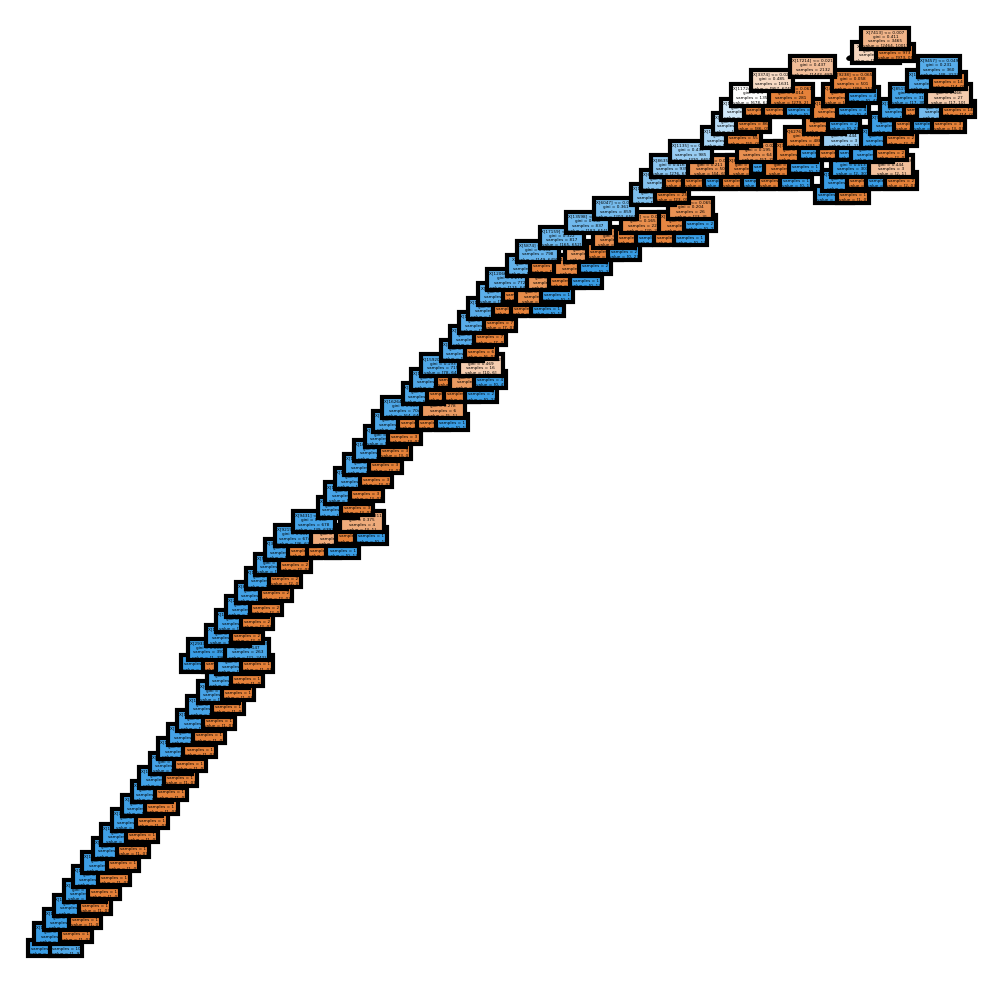

In [168]:
##Vizualising decision tree 
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(model.fit(X_train, y_train),
               filled = True);
fig.savefig('imagename.png')

In [92]:
##Running Multinomial NB Classifier
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, emailslistDF.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
print(accuracy_score(y_test, y_pred))

[[1181   27]
 [  25  474]]
0.9695371997656708


In [78]:
##Performing cross validation on the models   

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
models = [
    LinearSVC(),
    MultinomialNB(),
    DecisionTreeClassifier(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.954563
LinearSVC                 0.990526
MultinomialNB             0.968676
Name: accuracy, dtype: float64

In [93]:
## Investigating the differences in spam and ham emails that contribute to the high accuracy scores 
## looking at the word features of each category 
#using cleaned data to create frequency distributions 
hamtextscleanedDF = pd.DataFrame(hamtextscleaned, columns = ['Emails','Ham'])
print(hamtextscleanedDF.head())
hamtextsBOW = []
for ham in hamtextscleanedDF['Emails']:
    for h in ham: 
        hamtextsBOW.append(h)

hamtextsFD = nltk.FreqDist(hamtextsBOW)

for word, freq in hamtextsFD.most_common(10):
    print(word, freq)
    

                                              Emails  Ham
0  [ena, sales, hpl, update, project, status, bas...  ham
1  [ua, issues, referenced, meters, need, placed,...  ham
2  [hpl, nominations, december, see, attached, fi...  ham
3  [revised, nom, kcs, resources, daren, bob, for...  ham
4  [new, production, sitara, deals, needed, daren...  ham
ect 13897
hou 7281
enron 6555
gas 2861
deal 2789
com 2717
please 2715
meter 2459
cc 2359
pm 2325


In [94]:
#Creating frequency distributions for spam emails
spamtextscleanedDF = pd.DataFrame(spamtextscleaned, columns = ['Emails','Spam'])
print(spamtextscleanedDF.head())
spamtextsBOW = []
for spam in spamtextscleanedDF['Emails']:
    for s in spam: 
        spamtextsBOW.append(s)

spamtextsFD = nltk.FreqDist(spamtextsBOW)

for word, freq in spamtextsFD.most_common(10):
    print(word, freq)

                                              Emails  Spam
0  [cam, babe, looking, looking, companion, frien...  spam
1  [want, make, money, order, confirmation, order...  spam
2  [food, thoughts, join, take, free, tour, click...  spam
3  [miningnews, net, newsletter, tuesday, january...  spam
4  [pharmacy, ta, would, want, cheap, perscriptio...  spam
com 993
http 983
company 731
e 638
www 587
information 520
font 515
td 504
get 486
please 485


In [130]:
##Calculating how many of the document features appear in the feature set
total_spam = 0

for (word,freq) in word_items_cleaned:
    if word in spamtextsBOW:
        total_spam = total_spam + 1

In [131]:
print(total_spam)

1339


In [136]:
##Calculating how many of the document features appear in the feature set
total_ham = 0 
for (word,freq) in word_items_cleaned: 
    if word in hamtextsBOW:
        total_ham = total_ham + 1

In [137]:
print(total_ham)

1455


In [139]:
print(len(hamtextsBOW))

317498


In [140]:
print(len(spamtextsBOW))

178149
